# Setup

In [1]:
import sys
import os

# Get the absolute path to the repo root (parent of both src and notebook folders)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the repo root to the Python path
sys.path.append(repo_root)

# Now you can import from src
from src.master.data import load_and_crop_data
from src.master.visualize import show_masks_sam, visualize_masks

In [19]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2
from sam2.utils.misc import variant_to_config_mapping

model = build_sam2(
    variant_to_config_mapping["small"],
    "../models/sam2_hiera_small.pt",
)

mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=32,           # Increased from default 32
    pred_iou_thresh=0.7,          # Lowered from default 0.8
    stability_score_thresh=0.85,  # Lowered from default 0.95
    box_nms_thresh=0.6,           # Lowered from default 0.7
    )

Cropped image shape: (270, 250, 3)
Cropped mask shape: (270, 250)


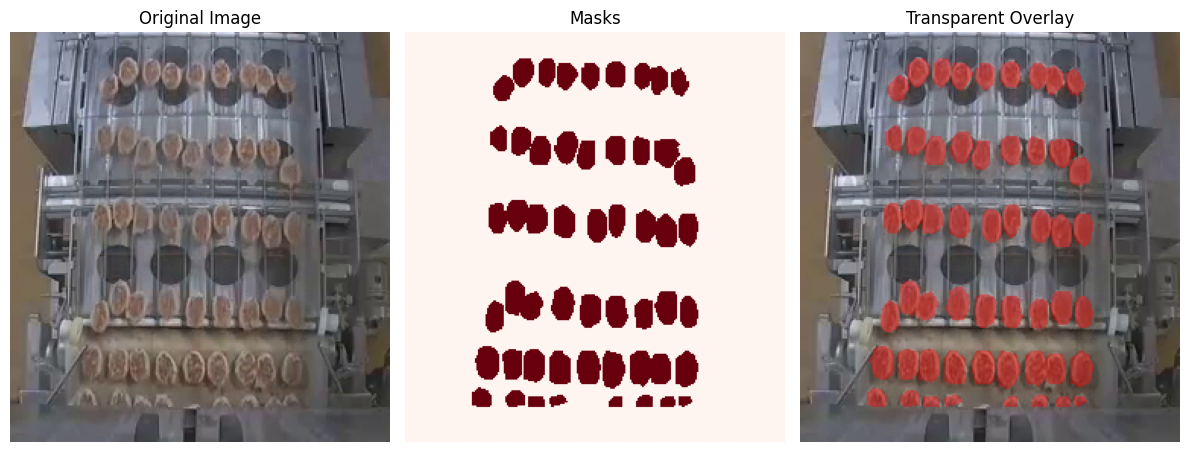

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


meatball_img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_001224.PNG"
meatball_label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/labels/train/frame_001224.txt"

cans_img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/cans/images/train/frame_000532.PNG"
cans_label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/cans/labels/train/frame_000532.txt"

doughs_img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/doughs/images/train/frame_001332.PNG"
doughs_label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/doughs/labels/train/frame_001332.txt"

bottles_img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/bottles/images/train/frame_000539.PNG"
bottles_label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/bottles/labels/train/frame_000539.txt"


# Define crop coordinates (y_start, y_end, x_start, x_end)
crop_coords = (30, 300, 200, 450)

# Load and crop both image and masks
meatball_img, meatball_masks_gt = load_and_crop_data(meatball_img_path, meatball_label_path, crop_coords)

# Verify dimensions
print(f"Cropped image shape: {meatball_img.shape}")
print(f"Cropped mask shape: {meatball_masks_gt[0].shape}")

# Visualize
visualize_masks(meatball_img, meatball_masks_gt)

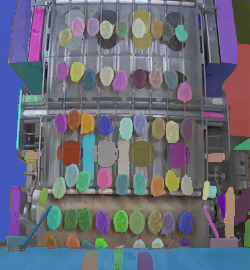

In [20]:
meatball_masks = mask_generator.generate(meatball_img)

meatball_output_mask = show_masks_sam(image = meatball_img, masks = meatball_masks, scores=None, only_best=False, autogenerated_mask=True)

meatball_output_mask

Cropped image shape: (550, 540, 3)
Cropped mask shape: (550, 540)


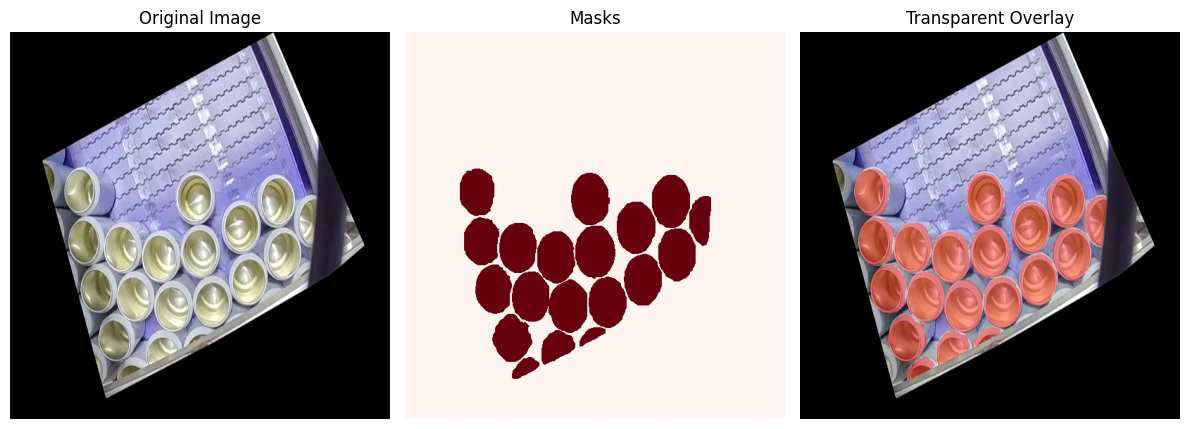

In [10]:
# Define crop coordinates (y_start, y_end, x_start, x_end)
crop_coords = (40, 590, 100, 640)

# Load and crop both image and masks
cans_img, cans_masks_gt = load_and_crop_data(cans_img_path, cans_label_path, crop_coords)

# Verify dimensions
print(f"Cropped image shape: {cans_img.shape}")
print(f"Cropped mask shape: {cans_masks_gt[0].shape}")

# Visualize
visualize_masks(cans_img, cans_masks_gt)

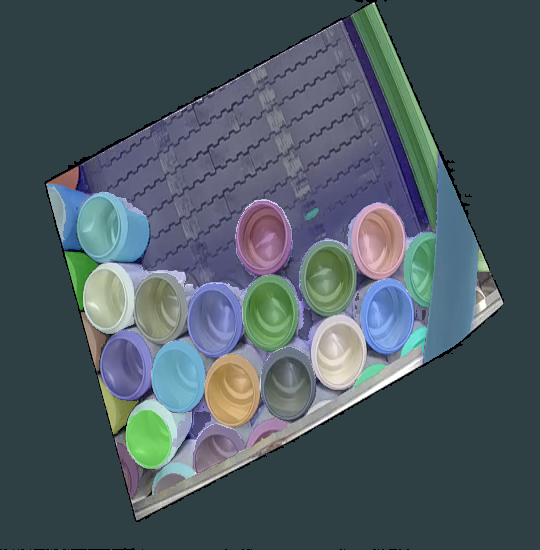

In [21]:
cans_masks = mask_generator.generate(cans_img)

cans_output_mask = show_masks_sam(image = cans_img, masks = cans_masks, scores=None, only_best=False, autogenerated_mask=True)

cans_output_mask

Cropped image shape: (590, 420, 3)
Cropped mask shape: (590, 420)


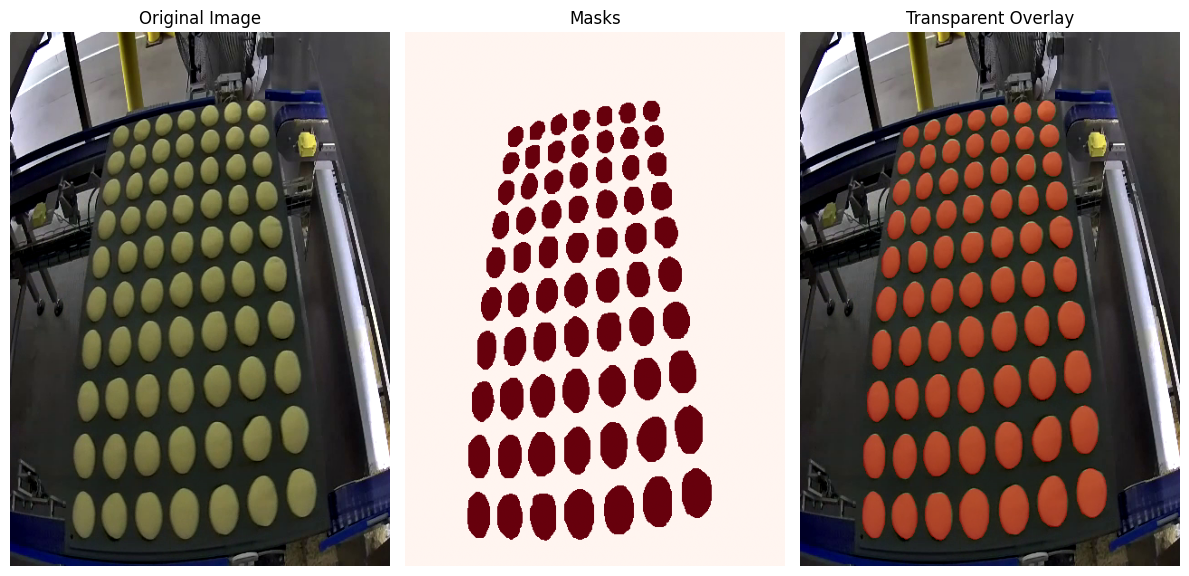

In [15]:
# Define crop coordinates (y_start, y_end, x_start, x_end)
crop_coords = (50, 640, 30, 450)

# Load and crop both image and masks
doughs_img, doughs_masks_gt = load_and_crop_data(doughs_img_path, doughs_label_path, crop_coords)

# Verify dimensions
print(f"Cropped image shape: {doughs_img.shape}")
print(f"Cropped mask shape: {doughs_masks_gt[0].shape}")

# Visualize
visualize_masks(doughs_img, doughs_masks_gt)

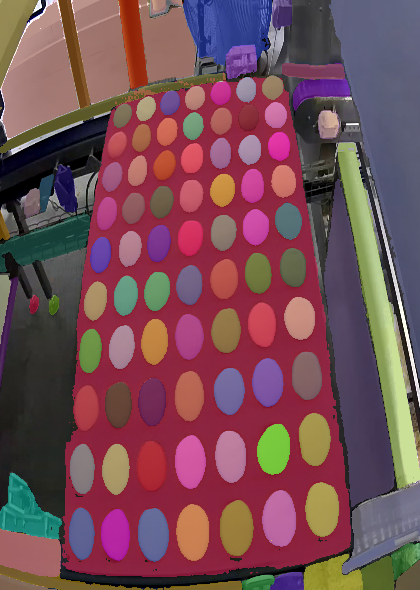

In [22]:
doughs_masks = mask_generator.generate(doughs_img)

doughs_output_mask = show_masks_sam(image = doughs_img, masks = doughs_masks, scores=None, only_best=False, autogenerated_mask=True)

doughs_output_mask

Cropped image shape: (380, 620, 3)
Cropped mask shape: (380, 620)


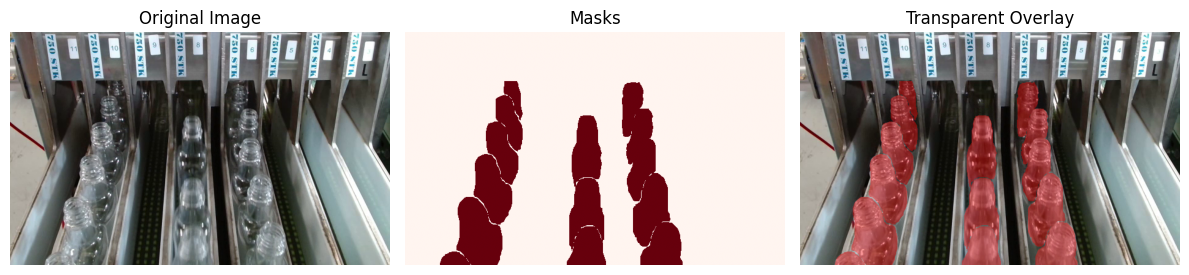

In [31]:
# Define crop coordinates (y_start, y_end, x_start, x_end)
crop_coords = (100, 480, 20, 640)

# Load and crop both image and masks
bottles_img, bottles_masks_gt = load_and_crop_data(bottles_img_path, bottles_label_path, crop_coords)

# Verify dimensions
print(f"Cropped image shape: {bottles_img.shape}")
print(f"Cropped mask shape: {bottles_masks_gt[0].shape}")

# Visualize
visualize_masks(bottles_img, bottles_masks_gt)

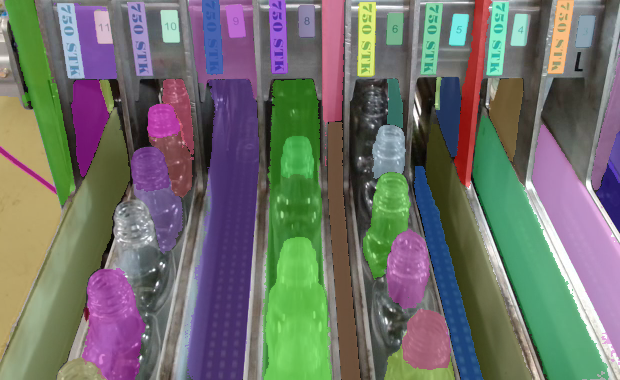

In [32]:
bottles_masks = mask_generator.generate(bottles_img)

bottles_output_mask = show_masks_sam(image = bottles_img, masks = bottles_masks, scores=None, only_best=False, autogenerated_mask=True)

bottles_output_mask

# HOG + SVM Baseline

In [1]:
import numpy as np
import cv2
from PIL import Image
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

class HOGSVMBaseline:
    """
    Traditional computer vision baseline using HOG features and SVM classifier
    """
    def __init__(self, hog_cell_size=(8, 8), hog_block_size=(2, 2), 
                 svm_kernel='rbf', svm_C=1.0):
        # HOG parameters
        self.hog_cell_size = hog_cell_size
        self.hog_block_size = hog_block_size
        
        # SVM parameters
        self.svm = SVC(kernel=svm_kernel, C=svm_C, probability=True)
        
        # For storing features and labels during training
        self.features = []
        self.labels = []
    
    def extract_features(self, image, mask):
        """Extract HOG features from the masked region"""
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        # Convert mask to numpy if it's not already
        if not isinstance(mask, np.ndarray):
            mask = np.array(mask)
        
        # Find bounding box of the mask
        if mask.sum() > 0:
            rows = np.any(mask, axis=1)
            cols = np.any(mask, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Add padding
            padding = 10
            y_min = max(0, y_min - padding)
            y_max = min(mask.shape[0], y_max + padding)
            x_min = max(0, x_min - padding)
            x_max = min(mask.shape[1], x_max + padding)
            
            # Crop the image
            if x_max > x_min and y_max > y_min:
                image_array = np.array(image)
                if len(image_array.shape) == 3:  # RGB
                    cropped_image = image_array[y_min:y_max, x_min:x_max]
                    cropped_mask = mask[y_min:y_max, x_min:x_max]
                    mask_3d = np.expand_dims(cropped_mask, axis=2).repeat(3, axis=2)
                    masked_image = cropped_image * mask_3d
                else:  # Grayscale
                    cropped_image = image_array[y_min:y_max, x_min:x_max]
                    cropped_mask = mask[y_min:y_max, x_min:x_max]
                    masked_image = cropped_image * cropped_mask
            else:
                masked_image = np.array(image)
        else:
            masked_image = np.array(image)
        
        # Convert to grayscale for HOG
        if len(masked_image.shape) == 3:
            gray_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
        else:
            gray_image = masked_image
        
        # Resize to a standard size
        resized_image = cv2.resize(gray_image, (64, 64))
        
        # Extract HOG features
        win_size = (64, 64)
        block_size = (self.hog_block_size[0] * self.hog_cell_size[0],
                      self.hog_block_size[1] * self.hog_cell_size[1])
        block_stride = (self.hog_cell_size[0], self.hog_cell_size[1])
        
        hog = cv2.HOGDescriptor(win_size, block_size, block_stride, 
                               self.hog_cell_size, 9)
        hog_features = hog.compute(resized_image)
        
        return hog_features.flatten()
    
    def fit(self, images, masks, labels=None):
        """Train the SVM classifier with HOG features"""
        self.features = []
        self.labels = []
        
        # Process inputs
        if not isinstance(images, list):
            images = [images]
        
        if not isinstance(masks, list):
            masks = [masks]
        
        # Process each image and mask
        for i in range(len(images)):
            image = images[i]
            
            # Handle one image with multiple masks
            if len(masks) > len(images) and i == 0:
                image_masks = masks
                
                # Get corresponding labels
                if labels is not None:
                    if isinstance(labels, list) and len(labels) == len(masks):
                        image_labels = labels
                    else:
                        image_labels = [1] * len(image_masks)
                else:
                    image_labels = [1] * len(image_masks)
                
                # Process each mask
                for j, mask in enumerate(image_masks):
                    try:
                        feature = self.extract_features(image, mask)
                        self.features.append(feature)
                        self.labels.append(image_labels[j])
                    except Exception as e:
                        print(f"Error processing mask {j}: {e}")
                        continue
            # Handle mask lists
            elif i < len(masks) and isinstance(masks[i], list):
                image_masks = masks[i]
                
                # Get labels
                if labels is not None:
                    if isinstance(labels[i], list):
                        image_labels = labels[i]
                    else:
                        image_labels = [labels[i]] * len(image_masks)
                else:
                    image_labels = [1] * len(image_masks)
                
                # Process each mask
                for j, mask in enumerate(image_masks):
                    try:
                        feature = self.extract_features(image, mask)
                        self.features.append(feature)
                        self.labels.append(image_labels[j])
                    except Exception as e:
                        print(f"Error processing mask {j}: {e}")
                        continue
            elif i < len(masks):
                # Single mask
                mask = masks[i]
                
                # Get label
                if labels is not None:
                    label = labels[i]
                else:
                    label = 1
                
                try:
                    feature = self.extract_features(image, mask)
                    self.features.append(feature)
                    self.labels.append(label)
                except Exception as e:
                    print(f"Error processing mask for image {i}: {e}")
                    continue
        
        # Check if we have features
        if len(self.features) > 0:
            # Standardize features
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(self.features)
            
            # Train SVM
            self.svm.fit(scaled_features, self.labels)
            return True
        else:
            print("No features extracted. Cannot train SVM.")
            return False
    
    def predict(self, image, candidate_masks, return_probabilities=True):
        """Predict class of candidate masks"""
        if not candidate_masks or len(candidate_masks) == 0:
            if return_probabilities:
                return [], []
            else:
                return []
        
        # Extract features
        features = []
        valid_masks = []
        
        for i, mask in enumerate(candidate_masks):
            try:
                feature = self.extract_features(image, mask)
                features.append(feature)
                valid_masks.append(mask)
            except Exception as e:
                print(f"Error extracting features for mask {i}: {e}")
                continue
        
        if not features:
            if return_probabilities:
                return [], []
            else:
                return []
        
        # Standardize features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Get predictions
        predictions = self.svm.predict(scaled_features)
        if return_probabilities:
            probabilities = self.svm.predict_proba(scaled_features)
            positive_probs = probabilities[:, 1] if probabilities.shape[1] > 1 else probabilities[:, 0]
        
        # Filter masks
        filtered_indices = [i for i, pred in enumerate(predictions) if pred == 1]
        filtered_masks = [valid_masks[i] for i in filtered_indices]
        
        if return_probabilities:
            filtered_probs = [positive_probs[i] for i in filtered_indices]
            return filtered_masks, filtered_probs
        else:
            return filtered_masks


# SIFT + Bag-Of-Words Baseline

In [2]:
class SIFTBagOfWordsBaseline:
    """
    SIFT features with Bag of Visual Words and SVM classifier
    """
    def __init__(self, n_clusters=100, svm_kernel='rbf', svm_C=1.0):
        # SIFT detector
        self.sift = cv2.SIFT_create()
        
        # K-means for visual vocabulary
        self.kmeans = None
        self.n_clusters = n_clusters
        
        # SVM classifier
        self.svm = SVC(kernel=svm_kernel, C=svm_C, probability=True)
        
        # Feature scaling
        self.scaler = StandardScaler()
        
        # For storing training data
        self.bow_features = []
        self.labels = []
        
        # Visual vocabulary (k-means clusters)
        self.vocabulary = None
    
    def extract_local_features(self, image, mask):
        """Extract SIFT features from the masked region"""
        if isinstance(image, np.ndarray):
            image_array = image
        else:
            image_array = np.array(image)
        
        if not isinstance(mask, np.ndarray):
            mask = np.array(mask)
        
        # Find bounding box of the mask
        if mask.sum() > 0:
            rows = np.any(mask, axis=1)
            cols = np.any(mask, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Add padding
            padding = 10
            y_min = max(0, y_min - padding)
            y_max = min(mask.shape[0], y_max + padding)
            x_min = max(0, x_min - padding)
            x_max = min(mask.shape[1], x_max + padding)
            
            # Check bounding box validity
            if x_max <= x_min or y_max <= y_min:
                cropped_region = image_array
                mask_for_keypoints = np.ones(image_array.shape[:2], dtype=np.uint8)
            else:
                # Crop image and mask
                cropped_region = image_array[y_min:y_max, x_min:x_max]
                cropped_mask = mask[y_min:y_max, x_min:x_max]
                
                # Create mask for keypoint detection
                if len(cropped_region.shape) == 3:
                    mask_for_keypoints = cropped_mask.astype(np.uint8)
                else:
                    mask_for_keypoints = cropped_mask.astype(np.uint8)
        else:
            cropped_region = image_array
            mask_for_keypoints = np.ones(image_array.shape[:2], dtype=np.uint8)
        
        # Convert to grayscale for SIFT
        if len(cropped_region.shape) == 3:
            gray_image = cv2.cvtColor(cropped_region, cv2.COLOR_RGB2GRAY)
        else:
            gray_image = cropped_region
        
        # Detect keypoints and descriptors
        keypoints, descriptors = self.sift.detectAndCompute(gray_image, mask=mask_for_keypoints)
        
        # Return empty array if no keypoints found
        if descriptors is None:
            return np.array([])
        
        return descriptors
    
    def extract_bow_features(self, image, mask):
        """Extract Bag of Words features using visual vocabulary"""
        if self.vocabulary is None:
            raise ValueError("Visual vocabulary not created. Call fit() first.")
        
        # Get local descriptors
        descriptors = self.extract_local_features(image, mask)
        
        if descriptors.size == 0:
            # No features found, return zeros
            return np.zeros(self.n_clusters)
        
        # Assign each descriptor to a visual word
        visual_words = self.kmeans.predict(descriptors)
        
        # Count occurrences of each visual word
        bow_histogram = np.zeros(self.n_clusters)
        for word in visual_words:
            bow_histogram[word] += 1
        
        # Normalize the histogram
        if bow_histogram.sum() > 0:
            bow_histogram = bow_histogram / bow_histogram.sum()
        
        return bow_histogram
    
    def create_vocabulary(self, all_descriptors):
        """Create visual vocabulary by clustering descriptors"""
        if all_descriptors.size == 0:
            raise ValueError("No descriptors provided for vocabulary creation")
        
        print(f"Creating vocabulary with {self.n_clusters} visual words...")
        
        # Limit the number of descriptors to avoid excessive memory usage
        max_descriptors = 100000
        if all_descriptors.shape[0] > max_descriptors:
            indices = np.random.choice(all_descriptors.shape[0], max_descriptors, replace=False)
            descriptors_sample = all_descriptors[indices]
        else:
            descriptors_sample = all_descriptors
        
        # Create vocabulary with k-means
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        self.kmeans.fit(descriptors_sample)
        
        self.vocabulary = self.kmeans.cluster_centers_
    
    def fit(self, images, masks, labels=None):
        """Train the SVM classifier with BoW features"""
        # Process inputs
        if not isinstance(images, list):
            images = [images]
        
        if not isinstance(masks, list):
            masks = [masks]
        
        # First pass: collect all descriptors for vocabulary creation
        all_descriptors = []
        
        for i in range(len(images)):
            image = images[i]
            
            # Handle one image with multiple masks
            if len(masks) > len(images) and i == 0:
                image_masks = masks
                
                for mask in image_masks:
                    try:
                        descriptors = self.extract_local_features(image, mask)
                        if descriptors.size > 0:
                            all_descriptors.append(descriptors)
                    except Exception as e:
                        print(f"Error extracting descriptors: {e}")
            # Handle mask lists
            elif i < len(masks) and isinstance(masks[i], list):
                image_masks = masks[i]
                
                for mask in image_masks:
                    try:
                        descriptors = self.extract_local_features(image, mask)
                        if descriptors.size > 0:
                            all_descriptors.append(descriptors)
                    except Exception as e:
                        print(f"Error extracting descriptors: {e}")
            elif i < len(masks):
                # Single mask
                mask = masks[i]
                
                try:
                    descriptors = self.extract_local_features(image, mask)
                    if descriptors.size > 0:
                        all_descriptors.append(descriptors)
                except Exception as e:
                    print(f"Error extracting descriptors: {e}")
        
        # Check if we have descriptors
        if not all_descriptors:
            print("No descriptors extracted. Cannot create vocabulary.")
            return False
        
        # Concatenate all descriptors
        all_descriptors = np.vstack(all_descriptors)
        
        # Create visual vocabulary
        self.create_vocabulary(all_descriptors)
        
        # Second pass: extract BoW features for each mask
        self.bow_features = []
        self.labels = []
        
        for i in range(len(images)):
            image = images[i]
            
            # Handle one image with multiple masks
            if len(masks) > len(images) and i == 0:
                image_masks = masks
                
                # Get corresponding labels
                if labels is not None:
                    if isinstance(labels, list) and len(labels) == len(masks):
                        image_labels = labels
                    else:
                        image_labels = [1] * len(image_masks)
                else:
                    image_labels = [1] * len(image_masks)
                
                # Process each mask
                for j, mask in enumerate(image_masks):
                    try:
                        bow_feature = self.extract_bow_features(image, mask)
                        self.bow_features.append(bow_feature)
                        self.labels.append(image_labels[j])
                    except Exception as e:
                        print(f"Error processing mask {j}: {e}")
                        continue
            # Handle mask lists
            elif i < len(masks) and isinstance(masks[i], list):
                image_masks = masks[i]
                
                # Get labels
                if labels is not None:
                    if isinstance(labels[i], list):
                        image_labels = labels[i]
                    else:
                        image_labels = [labels[i]] * len(image_masks)
                else:
                    image_labels = [1] * len(image_masks)
                
                # Process each mask
                for j, mask in enumerate(image_masks):
                    try:
                        bow_feature = self.extract_bow_features(image, mask)
                        self.bow_features.append(bow_feature)
                        self.labels.append(image_labels[j])
                    except Exception as e:
                        print(f"Error processing mask {j}: {e}")
                        continue
            elif i < len(masks):
                # Single mask
                mask = masks[i]
                
                # Get label
                if labels is not None:
                    label = labels[i]
                else:
                    label = 1
                
                try:
                    bow_feature = self.extract_bow_features(image, mask)
                    self.bow_features.append(bow_feature)
                    self.labels.append(label)
                except Exception as e:
                    print(f"Error processing mask for image {i}: {e}")
                    continue
        
        # Check if we have features
        if len(self.bow_features) > 0:
            # Scale features
            scaled_features = self.scaler.fit_transform(self.bow_features)
            
            # Train SVM
            self.svm.fit(scaled_features, self.labels)
            return True
        else:
            print("No BoW features extracted. Cannot train SVM.")
            return False
    
    def predict(self, image, candidate_masks, return_probabilities=True):
        """Predict class of candidate masks"""
        if not candidate_masks or len(candidate_masks) == 0:
            if return_probabilities:
                return [], []
            else:
                return []
            
        if self.vocabulary is None:
            print("Visual vocabulary not created. Call fit() first.")
            if return_probabilities:
                return [], []
            else:
                return []
        
        # Extract BoW features
        bow_features = []
        valid_masks = []
        
        for i, mask in enumerate(candidate_masks):
            try:
                bow_feature = self.extract_bow_features(image, mask)
                bow_features.append(bow_feature)
                valid_masks.append(mask)
            except Exception as e:
                print(f"Error extracting BoW features for mask {i}: {e}")
                continue
        
        if not bow_features:
            if return_probabilities:
                return [], []
            else:
                return []
        
        # Scale features
        scaled_features = self.scaler.transform(bow_features)
        
        # Get predictions
        predictions = self.svm.predict(scaled_features)
        if return_probabilities:
            probabilities = self.svm.predict_proba(scaled_features)
            positive_probs = probabilities[:, 1] if probabilities.shape[1] > 1 else probabilities[:, 0]
        
        # Filter masks
        filtered_indices = [i for i, pred in enumerate(predictions) if pred == 1]
        filtered_masks = [valid_masks[i] for i in filtered_indices]
        
        if return_probabilities:
            filtered_probs = [positive_probs[i] for i in filtered_indices]
            return filtered_masks, filtered_probs
        else:
            return filtered_masks